# Import Libraries & Data 

In [1]:
#import libraries for handling data
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
#to standardscale data for models that require standardscaler:
from sklearn.preprocessing import StandardScaler

#import imbalanced-learn to handle imbalanced classes
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE #SMOTE = Synthetic Minority Oversampling TEchnique
from imblearn.over_sampling import ADASYN #ADASYN = ADAptive SYNthetic oversampling
from imblearn.ensemble import BalancedRandomForestClassifier #balanced random forest randomly under-samples each boostrap sample to balance it... perhaps this will help my imbalanced RF model not predict all zeros?

#import CLASSIFICATION models [used for supervised learning (labeled data)]
from sklearn.neighbors import KNeighborsClassifier #dumb model, easy to interpret 
from sklearn.naive_bayes import GaussianNB #limitation: assuming all features are independent
from sklearn.linear_model import LogisticRegression #this is essentially a linear model with some differences
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC #this is essentially a linear model with some differences
#CART models (decision trees and variations)
from sklearn.tree import DecisionTreeClassifier #decision trees should never be used by themselves, generally use as CART model
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance, plot_tree
#import DummyClassifier for baseline comparison
from sklearn.dummy import DummyClassifier
#import CV for parameter tuning of best model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

#import metrics 
from sklearn.metrics import precision_recall_fscore_support, auc, average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, roc_curve, precision_recall_curve,f1_score, fbeta_score, confusion_matrix
#I could potentially use F1 score.. or a weighted F1 score (Fbeta) because I want to MINIMIZE false negatives--which will MAXIMIZE recall and therefore INCREASE my score.. but this is not commonly used and less intuitive, therefore I used ROC curve
#I will need to assess precision, though, as well to make sure I have a good balance between the 2 and weigh recall more heavily--since they both factor into the F1score
#A confusion matrix will come in handy to make sure my False Negatives are minimized
#from sklearn.inspection import permutation_importance <<<didn't work: Import Error: cannot import 'permutation_importance' from 'sklearn.inspection'
#from sklearn import inspection << works, but does not have permutation_importance method
#permutation to view my feature importance of categorical dummy variables
#!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

Using TensorFlow backend.


In [2]:
#unpickle my data
X_train = pd.read_pickle('X_train')
y_train = pd.read_pickle('y_train')
X_subtrain = pd.read_pickle('X_subtrain')
y_subtrain = pd.read_pickle('y_subtrain')
X_valid = pd.read_pickle('X_valid')
y_valid = pd.read_pickle('y_valid')


#As a reminder: Because I have many observations (large sample size), I can do a manual train-test and train-crossvalidation split (i.e., cross validate on 1 validation set). 

#However, later, I will check my results on my best model using the CV method on my TRAIN set and my train-vs.validation sets just to confirm I did not get unlucky with my validation set.  

# MVP

Dummy Classifier for Comparison

In [3]:
dc = DummyClassifier()
dc.fit(X_subtrain, y_subtrain)
print("Dummy_F1_mvp: {:6.4f}".format(f1_score(y_valid, dc.predict(X_valid))))
print("Dummy_Precision_mvp: {:6.4f}".format(precision_score(y_valid, dc.predict(X_valid))))
print("Dummy_Recall_mvp: {:6.4f}".format(recall_score(y_valid, dc.predict(X_valid))))

Dummy_F1_mvp: 0.2059
Dummy_Precision_mvp: 0.1735
Dummy_Recall_mvp: 0.1689


Since I care about recall and minimizing False Negatives, I will run a confusion matrix for each model

In [4]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

At this point, my **classifiers are imbalanced.** For my MVP, I am going to use the "Do Nothing" approach.

If the "Do Nothing" approach results in a poor metric, I want to deal with imbalanced data on my y_TRAIN. 

In [5]:
#LOGREGCV 
#(This was my best result after some manual tuning)
logregCV = LogisticRegressionCV(Cs=[100000,10000,1000,100,10,1,0.1,0.01,0.001], max_iter = 500)
logregCV.fit(X_train, y_train)
print("LogRegCV_F1_mvp: "+ str(f1_score(y_train, logregCV.predict(X_train))))
print("LogRegCV_Precision_mvp: "+ str(precision_score(y_train, logregCV.predict(X_train))))
print("LogRegCV_Recall_mvp: "+ str(recall_score(y_train, logregCV.predict(X_train))))
print("LogRegCV_mvp: ")
print(pd.DataFrame(np.transpose(precision_recall_fscore_support(y_train, logregCV.predict(X_train), beta = 1.5)),columns=['Precision','Recall','Fbeta','Support']))
print("LogRegCV_Best_C: "+ str(logregCV.C_))
print(logregCV.classes_)
print(logregCV.intercept_)
print(logregCV.coef_)

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristentokunaga/an

LogRegCV_F1_mvp: 0.5130174989329919
LogRegCV_Precision_mvp: 0.7484433374844334
LogRegCV_Recall_mvp: 0.39025974025974025
LogRegCV_mvp: 
   Precision    Recall     Fbeta  Support
0   0.896369  0.975733  0.949856   8324.0
1   0.748443  0.390260  0.457650   1540.0
LogRegCV_Best_C: [100000.]
[0 1]
[-1.35398809]
[[ 2.12429376e-02 -1.72398577e-04  8.12169352e-03  1.73882835e-04
   4.12307065e-03  3.99402626e-05 -3.45141209e-01 -4.65876008e-01
   8.84877058e-02 -3.01989876e-01  1.56904516e-01 -6.56046039e-01
  -3.15247943e-01  1.29396124e-01 -2.46329305e-01 -5.43923781e-01
  -4.40005992e-01  5.23423706e-01  1.02239499e-01  1.46564651e-01
  -3.23019439e-01 -7.93749521e-01 -2.48128918e-01 -1.80770918e-01
  -4.78462393e-01 -2.26385893e-01 -4.81360688e-02  2.52613874e-02
  -1.73866585e-01 -1.55672408e-01 -1.59204682e-01 -2.23640404e-01
  -2.10017600e-01 -1.05902777e-01 -2.84198703e-01 -7.86821895e-02
  -4.12854093e-02  1.49447473e-02 -2.34981829e-02  5.03933018e-02
  -1.34717316e-01 -2.43337297e-0

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


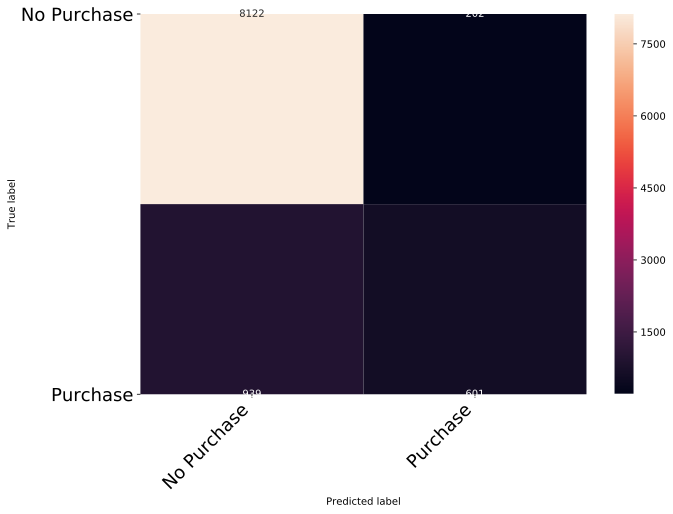

In [6]:
conf_mat = confusion_matrix(y_true=y_train, y_pred=logregCV.predict(X_train))
cm = print_confusion_matrix(conf_mat, ['No Purchase', 'Purchase'])

cm.savefig('mvp_confusion_matrix_logregCV')

In [7]:
#RF
#(This was my best result after some manual tuning)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=41)
randomforest.fit(X_subtrain, y_subtrain)
print(randomforest.feature_importances_)
#print(randomforest.predict(X_valid).size)
#print(y_valid.size)
print(f'RF_F1_mvp: {f1_score(y_valid, randomforest.predict(X_valid))}')
print(f'RF_Precision_mvp: {precision_score(y_valid, randomforest.predict(X_valid))}')
print(f'RF_Recall_mvp: {recall_score(y_valid, randomforest.predict(X_valid))}')

print("RF_mvp: ")
print(pd.DataFrame(np.transpose(precision_recall_fscore_support(randomforest.predict(X_valid), y_valid, beta = 1.5)),columns=['Precision','Recall','Fbeta','Support']))

# #My random forest F1 and precision are erroring out because it is predicting ALL zeros.. 

[8.47880661e-02 6.53203319e-02 2.72037430e-02 4.67646725e-02
 2.74732955e-02 6.56525272e-02 8.64178294e-02 1.53878519e-01
 2.79105213e-01 4.61305911e-03 3.91524994e-04 1.67756280e-03
 8.60988572e-04 0.00000000e+00 8.02853835e-04 5.16837909e-03
 1.10020371e-03 5.40442592e-02 1.07426171e-03 0.00000000e+00
 1.73603228e-02 2.14915227e-02 1.75488400e-04 2.72693063e-03
 4.86773063e-03 3.84339889e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.98597570e-05
 6.32538793e-04 0.00000000e+00 0.00000000e+00 4.08756154e-04
 0.00000000e+00 9.61928582e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.72864584e-04
 0.00000000e+00 1.65746419e-03 0.00000000e+00 5.18005271e-04
 3.91780208e-04 2.92356495e-03 1.23730161e-02 1.88816911e-02
 0.00000000e+00 7.11722432e-04 0.00000000e+00 1.01765892e-03
 1.79709063e-03 0.00000000e+00 6.80688847e-04 0.00000000e+00
 0.00000000e+00 3.95347971e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


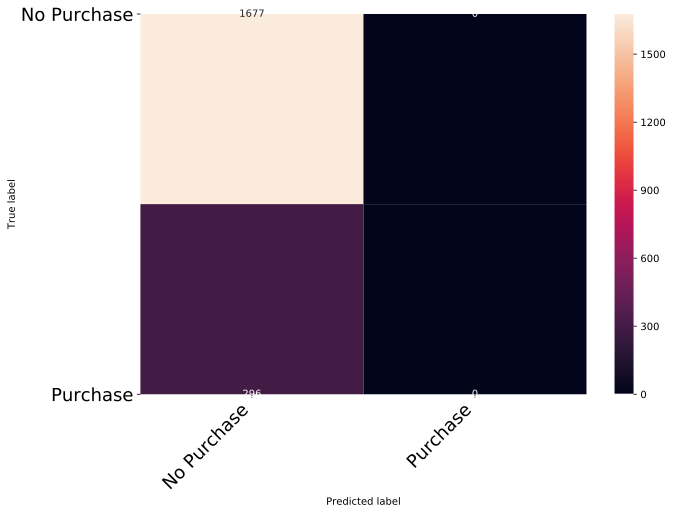

In [8]:
conf_mat = confusion_matrix(y_true=y_valid, y_pred=randomforest.predict(X_valid))
cm = print_confusion_matrix(conf_mat, ['No Purchase', 'Purchase'])

cm.savefig('mvp_confusion_matrix_RF')

In [9]:
#XGB
#(This was my best result after some manual tuning)
XGB = XGBClassifier(max_depth=2,n_estimators=95).fit(X_subtrain, y_subtrain)
print(f'XGB_F1_mvp: {f1_score(y_valid, XGB.predict(X_valid))}')
print(f'XGB_Precision_mvp: {precision_score(y_valid, XGB.predict(X_valid))}')
print(f'XGB_Recall_mvp: {recall_score(y_valid, XGB.predict(X_valid))}')
print(f'XGB_roc_auc: {roc_auc_score(y_valid, XGB.predict(X_valid))}')
print(pd.DataFrame(np.transpose(precision_recall_fscore_support(XGB.predict(X_valid), y_valid, beta = 2)),columns=['Precision','Recall','Fbeta','Support']))
print(XGB.feature_importances_)

p = precision_score(y_valid, XGB.predict(X_valid))
r = recall_score(y_valid, XGB.predict(X_valid))
y_scores = XGB.predict(X_valid)

XGB_F1_mvp: 0.6642984014209592
XGB_Precision_mvp: 0.700374531835206
XGB_Recall_mvp: 0.6317567567567568
XGB_roc_auc: 0.7920262615030057
   Precision    Recall     Fbeta  Support
0   0.952296  0.936108  0.939301   1706.0
1   0.631757  0.700375  0.685484    267.0
[0.02893072 0.02612789 0.         0.01839509 0.05365438 0.01647488
 0.09272814 0.04114718 0.40427232 0.         0.         0.
 0.         0.         0.         0.04224929 0.04169822 0.05968712
 0.01294899 0.01041857 0.01148833 0.03968834 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.0069581  0.
 0.         0.         0.         0.         0.         0.01319361
 0.         0.         0.         0.         0.         0.
 0.         0.0137238  0.         0.01292187 0.         0.0078044
 0.         0.         0.0168567  0.         0.01239005 0.00616255
 0.         0.01007945 0.         0.         0.         0.
 0.         0.        ]


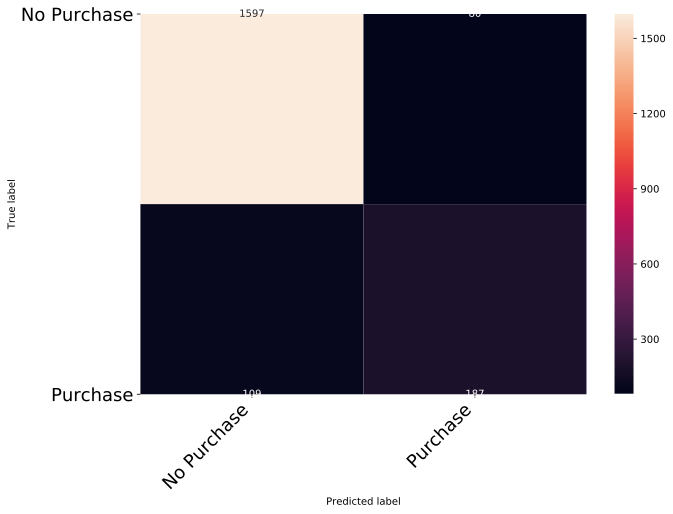

In [10]:
conf_mat = confusion_matrix(y_true=y_valid, y_pred=XGB.predict(X_valid))
cm = print_confusion_matrix(conf_mat, ['No Purchase', 'Purchase'])

cm.savefig('mvp_confusion_matrix_XGB')

#XGBoost is doing the best so far on this unbalanced dataset!

# Handle Imbalanced Data

I used 3 oversampling methods, and an extra option for XGBoost called scale_pos_weight--where I divide number of negatives by number of positives. 

In [11]:
#RANDOM Oversampling
#print(X_train.columns)
ros = RandomOverSampler(random_state=0)
X_ros_resampled_subtrain, y_ros_resampled_subtrain = ros.fit_sample(X_subtrain,y_subtrain)
X_ros_resampled_subtrain = pd.DataFrame(X_ros_resampled_subtrain, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
y_ros_resampled_subtrain = pd.DataFrame(y_ros_resampled_subtrain, columns = ['Purchase'])
y_ros_resampled_subtrain

#SMOTE Oversampling
X_smoted_subtrain, y_smoted_subtrain = SMOTE(random_state=0).fit_sample(X_subtrain,y_subtrain)
X_smoted_subtrain = pd.DataFrame(X_smoted_subtrain, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
y_smoted_subtrain = pd.DataFrame(y_smoted_subtrain, columns = ['Purchase'])
y_smoted_subtrain

#ADASYN Oversampling
X_adasyn_subtrain, y_adasyn_subtrain = ADASYN(random_state=0).fit_sample(X_subtrain,y_subtrain)
X_adasyn_subtrain = pd.DataFrame(X_adasyn_subtrain, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
y_adasyn_subtrain = pd.DataFrame(y_adasyn_subtrain, columns = ['Purchase'])
y_adasyn_subtrain

,Purchase
0,0
1,0
2,0
3,0
4,0
...,...
13154,1
13155,1
13156,1
13157,1


In [13]:
#All models - Imbalanced
Model_Results = pd.DataFrame(columns = ['Model','Fbeta1.5','Fbeta2', 'F1','Precision','Recall', 'P-R_AUC', 'ROC_AUC_train','ROC_AUC_valid','FN','FP','TN','TP','Fit','Predict','Feature_Importance'])
Model_Results['Model'] = ['Dummy_Clas','KNN_Clas_3n','KNN_Clas_5n','KNN_Clas_7n', 'KNN_Clas_3n_weightdist', 'KNN_Clas_3n_Manhattandist','GaussianNB','LogisticRegression','LogisticRegressionCV','SVC',\
                          'DecisionTree_Clas','BalRF_Clas_50est_depth2','BalRF_Clas_100est_depth2','BalRF_Clas_50est_depth3','RF_Clas_50est_depth2','RF_Clas_100est_depth2','RF_Clas_200est_depth2','RF_Clas_100est_depth3','RF_Clas_100est_depth4',\
                          'XGB_Clas_95est_depth2','XGB_Clas_Scale_95est_depth2_PosWt', 'XGB_Clas_100est_depth2','XGB_Clas_50est_depth2','XGB_Clas_95est_depth3','XGB_Clas_95est_depth4','XGB_Clas_95est_depth3_PosWt','XGB_Clas_Scale_100est_depth2_PosWt']
models = DummyClassifier(random_state=41), KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=5), KNeighborsClassifier(n_neighbors=7), KNeighborsClassifier(n_neighbors=3, weights='distance'),KNeighborsClassifier(n_neighbors=3, p=1), \
        GaussianNB(), LogisticRegression(C=1.0,random_state=41, max_iter=10000), LogisticRegressionCV(Cs=[100000,10000,1000,100,10,1,0.1,0.01,0.001],random_state=41,cv=5,max_iter=10000), SVC(random_state=41,probability=True), DecisionTreeClassifier(random_state=41), \
        BalancedRandomForestClassifier(n_estimators=50, max_depth=2,random_state=41), BalancedRandomForestClassifier(n_estimators=100, max_depth=2,random_state=41), BalancedRandomForestClassifier(n_estimators=50, max_depth=3,random_state=41), RandomForestClassifier(n_estimators=50, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=100, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=200, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=100, max_depth=3,random_state=41),RandomForestClassifier(n_estimators=100, max_depth=4,random_state=41), \
        XGBClassifier(max_depth=2,n_estimators=95,random_state=41), XGBClassifier(max_depth=2,n_estimators=95,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum()), XGBClassifier(max_depth=2,n_estimators=100,random_state=41), XGBClassifier(max_depth=2,n_estimators=50,random_state=41), XGBClassifier(max_depth=3,n_estimators=95,random_state=41),XGBClassifier(max_depth=4,n_estimators=95,random_state=41), XGBClassifier(max_depth=3,n_estimators=95,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum()), XGBClassifier(max_depth=2,n_estimators=100,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum())

fbeta1_5_list = []
fbeta2_list = []
f1_list = []
precision_list = []
recall_list = []
PR_AUC_list = []
ROC_AUC_train_list = []
ROC_AUC_valid_list = []
FN_list = []
FP_list = []
TN_list = []
TP_list = []
Fit_list = []
Predict_list = []
Feature_Importance_list = []


#std scale train and test: recommended workflow 
#scaler.fit x-->model.fit --> scaler transform x
#model.fit, scaler transform xtest 
#model learning from data training 
#scaled test --> leaks data
#train on trainset --if input data 

#pipeline --always gets this right
#scaler.fitx
#model.fit(scaler.transform(x))
#model.predict(scaler.transform(xtest)))
#stdscale target can do, but affects betas: less interpretable
#similar impact has similar beta 

for model in models:
    
    if 'CV' in str(model): 
        scalerlogregCV = StandardScaler().fit(X_train)
        X_train_transformed = scalerlogregCV.transform(X_train.values)
        X_train_transformed = pd.DataFrame(X_train_transformed, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
        model.fit(X_train_transformed,y_train) #turn back into df
        
        fbeta1_5_list.append(fbeta_score(y_train, model.predict(X_train_transformed),1.5))
        fbeta2_list.append(fbeta_score(y_train, model.predict(X_train_transformed),2))
        f1_list.append(f1_score(y_train, model.predict(X_train_transformed)))
        precision_list.append(precision_score(y_train, model.predict(X_train_transformed)))
        recall_list.append(recall_score(y_train, model.predict(X_train_transformed)))
        precision, recall, thresholds = precision_recall_curve(y_train, model.predict(X_train_transformed)) 
        PR_AUC_list.append(auc(recall, precision)) 
        ROC_AUC_train_list.append(roc_auc_score(y_train, model.predict(X_train_transformed)))
        ROC_AUC_valid_list.append(roc_auc_score(y_train, model.predict(X_train_transformed)))
        tn, fp, fn, tp = confusion_matrix(y_train, model.predict(X_train_transformed)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_train_transformed, y_train')
        Predict_list.append('X_train_transformed')
        Feature_Importance_list.append(model.coef_)
            
    elif 'LogisticRegression' in str(model):
        scalerlogreg = StandardScaler().fit(X_subtrain)
        X_subtrain_transformed = scalerlogreg.transform(X_subtrain.values)
        X_subtrain_transformed = pd.DataFrame(X_subtrain_transformed, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
        model.fit(X_subtrain_transformed,y_subtrain) #need to turn back into df
        X_valid_transformed = scalerlogreg.transform(X_valid)
        X_valid_transformed = pd.DataFrame(X_valid_transformed, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid_transformed),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid_transformed),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid_transformed)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid_transformed)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid_transformed)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid_transformed))
        PR_AUC_list.append(auc(recall, precision))
        ROC_AUC_train_list.append(roc_auc_score(y_subtrain, model.predict(X_subtrain_transformed)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid_transformed)))
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid_transformed)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_subtrain_transformed, y_subtrain')
        Predict_list.append('X_valid_transformed')
        Feature_Importance_list.append(model.coef_)
    
    elif 'DummyClassifier' in str(model) or 'KNeighborsClassifier' in str(model) or 'GaussianNB' in str(model) or 'SVC' in str(model):
        model.fit(X_subtrain,y_subtrain)
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid))
        PR_AUC_list.append(auc(recall, precision))
        ROC_AUC_train_list.append(roc_auc_score(y_subtrain, model.predict(X_subtrain)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid)))
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_subtrain, y_subtrain')
        Predict_list.append('X_valid')
        Feature_Importance_list.append('N/A')
        
    else:
        model.fit(X_subtrain,y_subtrain)
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid))
        PR_AUC_list.append(auc(recall, precision))
        ROC_AUC_train_list.append(roc_auc_score(y_subtrain, model.predict(X_subtrain)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid))) #technically, decision tree models should use OOB error to identify overfitting, but can't compare to other models
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_subtrain, y_subtrain')
        Predict_list.append('X_valid')
        Feature_Importance_list.append(model.feature_importances_)
        
Model_Results['Fbeta1.5'] = fbeta1_5_list
Model_Results['Fbeta2'] = fbeta2_list
Model_Results['F1'] = f1_list
Model_Results['Precision'] = precision_list
Model_Results['Recall'] = recall_list
Model_Results['P-R_AUC'] = PR_AUC_list
Model_Results['ROC_AUC_train'] = ROC_AUC_train_list
Model_Results['ROC_AUC_valid'] = ROC_AUC_valid_list   
Model_Results['FN'] = FN_list
Model_Results['FP'] = FP_list
Model_Results['TN'] = TN_list
Model_Results['TP'] = TP_list
Model_Results['Fit'] = Fit_list
Model_Results['Predict'] = Predict_list
Model_Results['Feature_Importance'] = Feature_Importance_list
Model_Results.sort_values(['FN', 'ROC_AUC_valid'], ascending=[1, 0])

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set 

,Model,Fbeta1.5,Fbeta2,F1,Precision,Recall,P-R_AUC,ROC_AUC_train,ROC_AUC_valid,FN,FP,TN,TP,Fit,Predict,Feature_Importance
25,XGB_Clas_95est_depth3_PosWt,0.714317,0.756024,0.650259,0.527311,0.847973,0.699046,0.877775,0.856902,45,225,1452,251,"X_subtrain, y_subtrain",X_valid,"[0.014539031, 0.014561205, 0.016836107, 0.0073..."
26,XGB_Clas_Scale_100est_depth2_PosWt,0.705779,0.746988,0.642487,0.521008,0.837838,0.691587,0.867550,0.850940,48,228,1449,248,"X_subtrain, y_subtrain",X_valid,"[0.02080161, 0.018758772, 0.012550266, 0.02189..."
12,BalRF_Clas_100est_depth2,0.680169,0.728127,0.608589,0.477842,0.837838,0.670004,0.847481,0.838120,48,271,1406,248,"X_subtrain, y_subtrain",X_valid,"[0.06347275114840684, 0.04200137368829416, 0.0..."
13,BalRF_Clas_50est_depth3,0.654752,0.708977,0.576074,0.438938,0.837838,0.650552,0.839016,0.824405,48,317,1360,248,"X_subtrain, y_subtrain",X_valid,"[0.05052678666208342, 0.06461612005159388, 0.0..."
20,XGB_Clas_Scale_95est_depth2_PosWt,0.706025,0.746224,0.644068,0.524416,0.834459,0.691855,0.866972,0.850444,49,224,1453,247,"X_subtrain, y_subtrain",X_valid,"[0.02088991, 0.020241043, 0.012380799, 0.02160..."
11,BalRF_Clas_50est_depth2,0.676044,0.721467,0.607721,0.481262,0.824324,0.665971,0.842127,0.833748,52,263,1414,244,"X_subtrain, y_subtrain",X_valid,"[0.06780604809620688, 0.05678131559595928, 0.0..."
6,GaussianNB,0.476862,0.527883,0.406674,0.294118,0.658784,0.502046,0.732416,0.689857,101,468,1209,195,"X_subtrain, y_subtrain",X_valid,N/A
19,XGB_Clas_95est_depth2,0.651393,0.644383,0.664298,0.700375,0.631757,0.693689,0.809096,0.792026,109,80,1597,187,"X_subtrain, y_subtrain",X_valid,"[0.028930724, 0.02612789, 0.0, 0.01839509, 0.0..."
21,XGB_Clas_100est_depth2,0.650000,0.643496,0.661947,0.695167,0.631757,0.691085,0.808066,0.791430,109,82,1595,187,"X_subtrain, y_subtrain",X_valid,"[0.029588066, 0.024347782, 0.0, 0.018813051, 0..."
24,XGB_Clas_95est_depth4,0.645092,0.636678,0.660682,0.704981,0.621622,0.691684,0.831414,0.787853,112,77,1600,184,"X_subtrain, y_subtrain",X_valid,"[0.020350646, 0.016022231, 0.0136688035, 0.011..."


In [14]:
print(y_subtrain.value_counts())
print((y_subtrain.values==0).sum())
(y_subtrain.values==1).sum()

0    6647
1    1244
Name: Purchase, dtype: int64
6647


1244

In [16]:
#All models - Random Oversample
Model_Results_ROS = pd.DataFrame(columns = ['Model','Fbeta1.5','Fbeta2', 'F1','Precision','Recall', 'P-R_AUC', 'ROC_AUC_train','ROC_AUC_valid','FN','FP','TN','TP','Fit','Predict','Feature_Importance'])
Model_Results_ROS['Model'] = ['Dummy_Clas','KNN_Clas_3n','KNN_Clas_5n','KNN_Clas_7n', 'KNN_Clas_3n_weightdist', 'KNN_Clas_3n_Manhattandist','GaussianNB','LogisticRegression','LogisticRegressionCV','SVC',\
                          'DecisionTree_Clas','BalRF_Clas_50est_depth2','BalRF_Clas_100est_depth2','BalRF_Clas_50est_depth3','RF_Clas_50est_depth2','RF_Clas_100est_depth2','RF_Clas_200est_depth2','RF_Clas_100est_depth3','RF_Clas_100est_depth4',\
                          'XGB_Clas_95est_depth2','XGB_Clas_Scale_95est_depth2_PosWt', 'XGB_Clas_100est_depth2','XGB_Clas_50est_depth2','XGB_Clas_95est_depth3','XGB_Clas_95est_depth4','XGB_Clas_95est_depth3_PosWt','XGB_Clas_Scale_100est_depth2_PosWt']
models = DummyClassifier(random_state=41), KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=5), KNeighborsClassifier(n_neighbors=7), KNeighborsClassifier(n_neighbors=3, weights='distance'),KNeighborsClassifier(n_neighbors=3, p=1), \
        GaussianNB(), LogisticRegression(C=1.0,random_state=41, max_iter=10000), LogisticRegressionCV(Cs=[100000,10000,1000,100,10,1,0.1,0.01,0.001],random_state=41,cv=5,max_iter=10000), SVC(random_state=41,probability=True), DecisionTreeClassifier(random_state=41), \
        BalancedRandomForestClassifier(n_estimators=50, max_depth=2,random_state=41), BalancedRandomForestClassifier(n_estimators=100, max_depth=2,random_state=41), BalancedRandomForestClassifier(n_estimators=50, max_depth=3,random_state=41), RandomForestClassifier(n_estimators=50, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=100, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=200, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=100, max_depth=3,random_state=41),RandomForestClassifier(n_estimators=100, max_depth=4,random_state=41), \
        XGBClassifier(max_depth=2,n_estimators=95,random_state=41), XGBClassifier(max_depth=2,n_estimators=95,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum()), XGBClassifier(max_depth=2,n_estimators=100,random_state=41), XGBClassifier(max_depth=2,n_estimators=50,random_state=41), XGBClassifier(max_depth=3,n_estimators=95,random_state=41),XGBClassifier(max_depth=4,n_estimators=95,random_state=41), XGBClassifier(max_depth=3,n_estimators=95,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum()), XGBClassifier(max_depth=2,n_estimators=100,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum())

fbeta1_5_list = []
fbeta2_list = []
f1_list = []
precision_list = []
recall_list = []
PR_AUC_list = []
ROC_AUC_train_list = []
ROC_AUC_valid_list = []
FN_list = []
FP_list = []
TN_list = []
TP_list = []
Fit_list = []
Predict_list = []
Feature_Importance_list = []

for model in models:
   
    if 'LogisticRegression' in str(model): 
        scalerlogreg = StandardScaler().fit(X_ros_resampled_subtrain)
        X_ros_resampled_subtrain_transformed = scalerlogreg.transform(X_ros_resampled_subtrain.values)
        X_ros_resampled_subtrain_transformed = pd.DataFrame(X_ros_resampled_subtrain_transformed, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
        model.fit(X_ros_resampled_subtrain_transformed,y_ros_resampled_subtrain.values.ravel()) #need to turn back into df
        X_valid_transformed = scalerlogreg.transform(X_valid)
        X_valid_transformed = pd.DataFrame(X_valid_transformed, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
        #model.fit(X_ros_resampled_subtrain,y_ros_resampled_subtrain.values.ravel())
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid_transformed),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid_transformed),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid_transformed)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid_transformed)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid_transformed)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid_transformed))
        PR_AUC_list.append(auc(recall, precision)) #manual calculation of AUC of P-R curve
        ROC_AUC_train_list.append(roc_auc_score(y_ros_resampled_subtrain, model.predict(X_ros_resampled_subtrain_transformed)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid_transformed)))
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid_transformed)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_ros_resampled_subtrain_transformed, y_ros_resampled_subtrain')
        Predict_list.append('X_valid_transformed')
        Feature_Importance_list.append(model.coef_)
    
    elif 'DummyClassifier' in str(model) or 'KNeighborsClassifier' in str(model) or 'GaussianNB' in str(model) or 'SVC' in str(model):
        model.fit(X_ros_resampled_subtrain,y_ros_resampled_subtrain.values.ravel())
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid))
        PR_AUC_list.append(auc(recall, precision)) #manual calculation of AUC of P-R curve 
        ROC_AUC_train_list.append(roc_auc_score(y_ros_resampled_subtrain, model.predict(X_ros_resampled_subtrain)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid)))
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_ros_resampled_subtrain, y_ros_resampled_subtrain')
        Predict_list.append('X_valid')
        Feature_Importance_list.append('N/A')
        
    else:
        model.fit(X_ros_resampled_subtrain,y_ros_resampled_subtrain.values.ravel())
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid))
        PR_AUC_list.append(auc(recall, precision)) #manual calculation of AUC of P-R curve - this is viewed by some as overly-optimistic measure of classifier performance because it relies on linear interpolation to calc AUC with trapezoidal rule
        ROC_AUC_train_list.append(roc_auc_score(y_ros_resampled_subtrain, model.predict(X_ros_resampled_subtrain)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid)))
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_ros_resampled_subtrain, y_ros_resampled_subtrain')
        Predict_list.append('X_valid')
        Feature_Importance_list.append(model.feature_importances_)

Model_Results_ROS['Fbeta1.5'] = fbeta1_5_list
Model_Results_ROS['Fbeta2'] = fbeta2_list
Model_Results_ROS['F1'] = f1_list
Model_Results_ROS['Precision'] = precision_list
Model_Results_ROS['Recall'] = recall_list
Model_Results_ROS['P-R_AUC'] = PR_AUC_list
Model_Results_ROS['ROC_AUC_train'] = ROC_AUC_train_list
Model_Results_ROS['ROC_AUC_valid'] = ROC_AUC_valid_list
Model_Results_ROS['FN'] = FN_list
Model_Results_ROS['FP'] = FP_list
Model_Results_ROS['TN'] = TN_list
Model_Results_ROS['TP'] = TP_list
Model_Results_ROS['Fit'] = Fit_list
Model_Results_ROS['Predict'] = Predict_list
Model_Results_ROS['Feature_Importance'] = Feature_Importance_list
Model_Results_ROS.sort_values(['ROC_AUC_valid','FN'], ascending=[0,1])

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,Model,Fbeta1.5,Fbeta2,F1,Precision,Recall,P-R_AUC,ROC_AUC_train,ROC_AUC_valid,FN,FP,TN,TP,Fit,Predict,Feature_Importance
22,XGB_Clas_50est_depth2,0.717342,0.752457,0.662162,0.551802,0.827703,0.702677,0.856928,0.854519,51,199,1478,245,"X_ros_resampled_subtrain, y_ros_resampled_subt...",X_valid,"[0.019326052, 0.039046638, 0.0, 0.0, 0.0525512..."
23,XGB_Clas_95est_depth3,0.710227,0.752106,0.645995,0.523013,0.844595,0.695461,0.880096,0.854319,46,228,1449,250,"X_ros_resampled_subtrain, y_ros_resampled_subt...",X_valid,"[0.019297283, 0.01373089, 0.0071944967, 0.0078..."
24,XGB_Clas_95est_depth4,0.710303,0.747407,0.652463,0.538462,0.827703,0.696007,0.900181,0.851240,51,210,1467,245,"X_ros_resampled_subtrain, y_ros_resampled_subt...",X_valid,"[0.014379468, 0.013422387, 0.013478108, 0.0102..."
19,XGB_Clas_95est_depth2,0.708149,0.746812,0.648221,0.531317,0.831081,0.693870,0.867008,0.850842,50,217,1460,246,"X_ros_resampled_subtrain, y_ros_resampled_subt...",X_valid,"[0.021318242, 0.021741973, 0.010360382, 0.0177..."
21,XGB_Clas_100est_depth2,0.703550,0.744424,0.640726,0.520000,0.834459,0.689647,0.867685,0.849251,49,228,1449,247,"X_ros_resampled_subtrain, y_ros_resampled_subt...",X_valid,"[0.02139723, 0.018425675, 0.010398768, 0.01778..."
11,BalRF_Clas_50est_depth2,0.699912,0.738946,0.639581,0.522484,0.824324,0.686582,0.847977,0.845674,52,223,1454,244,"X_ros_resampled_subtrain, y_ros_resampled_subt...",X_valid,"[0.08602271542300201, 0.06079490867007325, 0.0..."
18,RF_Clas_100est_depth4,0.689728,0.737028,0.618812,0.488281,0.844595,0.678095,0.852039,0.844182,46,262,1415,250,"X_ros_resampled_subtrain, y_ros_resampled_subt...",X_valid,"[0.0524352581207592, 0.040554330550011494, 0.0..."
17,RF_Clas_100est_depth3,0.678780,0.728863,0.604595,0.470810,0.844595,0.669360,0.847751,0.838517,46,281,1396,250,"X_ros_resampled_subtrain, y_ros_resampled_subt...",X_valid,"[0.05829203125442785, 0.04811441822330623, 0.0..."
14,RF_Clas_50est_depth2,0.685727,0.722965,0.627968,0.515152,0.804054,0.674301,0.842937,0.835241,58,224,1453,238,"X_ros_resampled_subtrain, y_ros_resampled_subt...",X_valid,"[0.05640539643256823, 0.03261558099584248, 0.0..."
15,RF_Clas_100est_depth2,0.674894,0.720614,0.606211,0.479371,0.824324,0.665026,0.846698,0.833152,52,265,1412,244,"X_ros_resampled_subtrain, y_ros_resampled_subt...",X_valid,"[0.08846629678770805, 0.062175243164118404, 0...."


In [17]:
#All models - SMOTE Oversample
Model_Results_SMOTE = pd.DataFrame(columns = ['Model','Fbeta1.5','Fbeta2', 'F1','Precision','Recall', 'P-R_AUC', 'ROC_AUC_train','ROC_AUC_valid','FN','FP','TN','TP','Fit','Predict','Feature_Importance'])
Model_Results_SMOTE['Model'] = ['Dummy_Clas','KNN_Clas_3n','KNN_Clas_5n','KNN_Clas_7n', 'KNN_Clas_3n_weightdist', 'KNN_Clas_3n_Manhattandist','GaussianNB','LogisticRegression','LogisticRegressionCV','SVC',\
                          'DecisionTree_Clas','BalRF_Clas_50est_depth2','BalRF_Clas_100est_depth2','BalRF_Clas_50est_depth3','RF_Clas_50est_depth2','RF_Clas_100est_depth2','RF_Clas_200est_depth2','RF_Clas_100est_depth3','RF_Clas_100est_depth4',\
                          'XGB_Clas_95est_depth2','XGB_Clas_Scale_95est_depth2_PosWt', 'XGB_Clas_100est_depth2','XGB_Clas_50est_depth2','XGB_Clas_95est_depth3','XGB_Clas_95est_depth4','XGB_Clas_95est_depth3_PosWt','XGB_Clas_Scale_100est_depth2_PosWt']
models = DummyClassifier(random_state=41), KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=5), KNeighborsClassifier(n_neighbors=7), KNeighborsClassifier(n_neighbors=3, weights='distance'),KNeighborsClassifier(n_neighbors=3, p=1), \
        GaussianNB(), LogisticRegression(C=1.0,random_state=41, max_iter=10000), LogisticRegressionCV(Cs=[100000,10000,1000,100,10,1,0.1,0.01,0.001],random_state=41,cv=5,max_iter=10000), SVC(random_state=41,probability=True), DecisionTreeClassifier(random_state=41), \
        BalancedRandomForestClassifier(n_estimators=50, max_depth=2,random_state=41), BalancedRandomForestClassifier(n_estimators=100, max_depth=2,random_state=41), BalancedRandomForestClassifier(n_estimators=50, max_depth=3,random_state=41), RandomForestClassifier(n_estimators=50, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=100, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=200, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=100, max_depth=3,random_state=41),RandomForestClassifier(n_estimators=100, max_depth=4,random_state=41), \
        XGBClassifier(max_depth=2,n_estimators=95,random_state=41), XGBClassifier(max_depth=2,n_estimators=95,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum()), XGBClassifier(max_depth=2,n_estimators=100,random_state=41), XGBClassifier(max_depth=2,n_estimators=50,random_state=41), XGBClassifier(max_depth=3,n_estimators=95,random_state=41),XGBClassifier(max_depth=4,n_estimators=95,random_state=41), XGBClassifier(max_depth=3,n_estimators=95,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum()), XGBClassifier(max_depth=2,n_estimators=100,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum())


fbeta1_5_list = []
fbeta2_list = []
f1_list = []
precision_list = []
recall_list = []
PR_AUC_list = []
ROC_AUC_train_list = []
ROC_AUC_valid_list = []
FN_list = []
FP_list = []
TN_list = []
TP_list = []
Fit_list = []
Predict_list = []
Feature_Importance_list = []

for model in models:
    
    if 'LogisticRegression' in str(model): 
        scalerlogreg = StandardScaler().fit(X_smoted_subtrain)
        X_smoted_subtrain_transformed = scalerlogreg.transform(X_smoted_subtrain.values)
        X_smoted_subtrain_transformed = pd.DataFrame(X_smoted_subtrain_transformed, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
        model.fit(X_smoted_subtrain_transformed,y_smoted_subtrain.values.ravel()) 
        X_valid_transformed = scalerlogreg.transform(X_valid)
        X_valid_transformed = pd.DataFrame(X_valid_transformed, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid_transformed),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid_transformed),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid_transformed)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid_transformed)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid_transformed)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid_transformed))
        PR_AUC_list.append(auc(recall, precision))
        ROC_AUC_train_list.append(roc_auc_score(y_smoted_subtrain, model.predict(X_smoted_subtrain_transformed)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid_transformed)))
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid_transformed)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_smoted_subtrain_transformed, y_smoted_subtrain')
        Predict_list.append('X_valid_transformed') 
        Feature_Importance_list.append(model.coef_)
        
    elif 'DummyClassifier' in str(model) or 'KNeighborsClassifier' in str(model) or 'GaussianNB' in str(model) or 'SVC' in str(model):
        model.fit(X_smoted_subtrain,y_smoted_subtrain.values.ravel())
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid))
        PR_AUC_list.append(auc(recall, precision))
        ROC_AUC_train_list.append(roc_auc_score(y_smoted_subtrain, model.predict(X_smoted_subtrain)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid)))
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_smoted_subtrain, y_smoted_subtrain')
        Predict_list.append('X_valid')
        Feature_Importance_list.append('N/A')
       
    else:
        model.fit(X_smoted_subtrain,y_smoted_subtrain.values.ravel())
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid))
        PR_AUC_list.append(auc(recall, precision))
        ROC_AUC_train_list.append(roc_auc_score(y_smoted_subtrain, model.predict(X_smoted_subtrain)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid)))
        #Model_Results['Decision_Threshold'] = 
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_smoted_subtrain, y_smoted_subtrain')
        Predict_list.append('X_valid')
        Feature_Importance_list.append(model.feature_importances_)
        
Model_Results_SMOTE['Fbeta1.5'] = fbeta1_5_list
Model_Results_SMOTE['Fbeta2'] = fbeta2_list
Model_Results_SMOTE['F1'] = f1_list
Model_Results_SMOTE['Precision'] = precision_list
Model_Results_SMOTE['Recall'] = recall_list
Model_Results_SMOTE['P-R_AUC'] = PR_AUC_list
Model_Results_SMOTE['ROC_AUC_train'] = ROC_AUC_train_list
Model_Results_SMOTE['ROC_AUC_valid'] = ROC_AUC_valid_list
Model_Results_SMOTE['FN'] = FN_list
Model_Results_SMOTE['FP'] = FP_list
Model_Results_SMOTE['TN'] = TN_list
Model_Results_SMOTE['TP'] = TP_list
Model_Results_SMOTE['Fit'] = Fit_list
Model_Results_SMOTE['Predict'] = Predict_list
Model_Results_SMOTE['Feature_Importance'] = Feature_Importance_list
print(len(Model_Results['Feature_Importance']))
Model_Results_SMOTE.sort_values(['ROC_AUC_valid','FN'], ascending=[0,1])

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


27


,Model,Fbeta1.5,Fbeta2,F1,Precision,Recall,P-R_AUC,ROC_AUC_train,ROC_AUC_valid,FN,FP,TN,TP,Fit,Predict,Feature_Importance
25,XGB_Clas_95est_depth3_PosWt,0.703216,0.755102,0.626360,0.487759,0.875000,0.690756,0.912818,0.856403,37,272,1405,259,"X_smoted_subtrain, y_smoted_subtrain",X_valid,"[0.011354925, 0.008951612, 0.009714933, 0.0060..."
26,XGB_Clas_Scale_100est_depth2_PosWt,0.668967,0.730683,0.581292,0.433555,0.881757,0.666526,0.895216,0.839209,35,341,1336,261,"X_smoted_subtrain, y_smoted_subtrain",X_valid,"[0.019549906, 0.0, 0.010513124, 0.004076822, 0..."
20,XGB_Clas_Scale_95est_depth2_PosWt,0.666339,0.728643,0.578073,0.429984,0.881757,0.664740,0.894313,0.837718,35,346,1331,261,"X_smoted_subtrain, y_smoted_subtrain",X_valid,"[0.02151087, 0.0, 0.010248257, 0.0039741113, 0..."
22,XGB_Clas_50est_depth2,0.701951,0.723391,0.666667,0.589610,0.766892,0.695737,0.925756,0.836338,69,158,1519,227,"X_smoted_subtrain, y_smoted_subtrain",X_valid,"[0.02921356, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018767..."
13,BalRF_Clas_50est_depth3,0.681404,0.712074,0.632737,0.533643,0.777027,0.672061,0.908004,0.828585,66,201,1476,230,"X_smoted_subtrain, y_smoted_subtrain",X_valid,"[0.06207008022217814, 0.03438663438605187, 0.0..."
21,XGB_Clas_100est_depth2,0.684718,0.696534,0.664587,0.617391,0.719595,0.689527,0.938318,0.820441,83,132,1545,213,"X_smoted_subtrain, y_smoted_subtrain",X_valid,"[0.0072183167, 0.0035270064, 0.0, 0.002690102,..."
11,BalRF_Clas_50est_depth2,0.665698,0.699878,0.612299,0.506637,0.773649,0.657122,0.899880,0.820337,67,223,1454,229,"X_smoted_subtrain, y_smoted_subtrain",X_valid,"[0.06389802575039347, 0.05128477588570693, 0.0..."
19,XGB_Clas_95est_depth2,0.683366,0.695624,0.662519,0.613833,0.719595,0.687748,0.938017,0.819845,83,134,1543,213,"X_smoted_subtrain, y_smoted_subtrain",X_valid,"[0.00705315, 0.0039140154, 0.0, 0.002628548, 0..."
18,RF_Clas_100est_depth4,0.669118,0.697385,0.623955,0.530806,0.756757,0.662028,0.914774,0.819344,72,198,1479,224,"X_smoted_subtrain, y_smoted_subtrain",X_valid,"[0.060812569221795655, 0.02800887505815617, 0...."
24,XGB_Clas_95est_depth4,0.683163,0.687583,0.675410,0.656051,0.695946,0.698806,0.952685,0.815773,90,108,1569,206,"X_smoted_subtrain, y_smoted_subtrain",X_valid,"[0.008228816, 0.005958187, 0.0095503265, 0.003..."


In [18]:
#All Models - ADASYN Oversample
Model_Results_ADASYN = pd.DataFrame(columns = ['Model','Fbeta1.5','Fbeta2', 'F1','Precision','Recall', 'P-R_AUC', 'ROC_AUC_valid','FN','FP','TN','TP','Fit','Predict','Feature_Importance'])
Model_Results_ADASYN['Model'] = ['Dummy_Clas','KNN_Clas_3n','KNN_Clas_5n','KNN_Clas_7n', 'KNN_Clas_3n_weightdist', 'KNN_Clas_3n_Manhattandist','GaussianNB','LogisticRegression','LogisticRegressionCV','SVC',\
                          'DecisionTree_Clas','BalRF_Clas_50est_depth2','BalRF_Clas_100est_depth2','BalRF_Clas_50est_depth3','RF_Clas_50est_depth2','RF_Clas_100est_depth2','RF_Clas_200est_depth2','RF_Clas_100est_depth3','RF_Clas_100est_depth4',\
                          'XGB_Clas_95est_depth2','XGB_Clas_Scale_95est_depth2_PosWt', 'XGB_Clas_100est_depth2','XGB_Clas_50est_depth2','XGB_Clas_95est_depth3','XGB_Clas_95est_depth4','XGB_Clas_95est_depth3_PosWt','XGB_Clas_Scale_100est_depth2_PosWt']
models = DummyClassifier(random_state=41), KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=5), KNeighborsClassifier(n_neighbors=7), KNeighborsClassifier(n_neighbors=3, weights='distance'),KNeighborsClassifier(n_neighbors=3, p=1), \
        GaussianNB(), LogisticRegression(C=1.0,random_state=41, max_iter=10000), LogisticRegressionCV(Cs=[100000,10000,1000,100,10,1,0.1,0.01,0.001],random_state=41,cv=5,max_iter=10000), SVC(random_state=41,probability=True), DecisionTreeClassifier(random_state=41), \
        BalancedRandomForestClassifier(n_estimators=50, max_depth=2,random_state=41), BalancedRandomForestClassifier(n_estimators=100, max_depth=2,random_state=41), BalancedRandomForestClassifier(n_estimators=50, max_depth=3,random_state=41), RandomForestClassifier(n_estimators=50, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=100, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=200, max_depth=2,random_state=41), RandomForestClassifier(n_estimators=100, max_depth=3,random_state=41),RandomForestClassifier(n_estimators=100, max_depth=4,random_state=41), \
        XGBClassifier(max_depth=2,n_estimators=95,random_state=41), XGBClassifier(max_depth=2,n_estimators=95,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum()), XGBClassifier(max_depth=2,n_estimators=100,random_state=41), XGBClassifier(max_depth=2,n_estimators=50,random_state=41), XGBClassifier(max_depth=3,n_estimators=95,random_state=41),XGBClassifier(max_depth=4,n_estimators=95,random_state=41), XGBClassifier(max_depth=3,n_estimators=95,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum()), XGBClassifier(max_depth=2,n_estimators=100,random_state=41,scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum())


fbeta1_5_list = []
fbeta2_list = []
f1_list = []
precision_list = []
recall_list = []
PR_AUC_list = []
ROC_AUC_train_list = []
ROC_AUC_valid_list = []
FN_list = []
FP_list = []
TN_list = []
TP_list = []
Fit_list = []
Predict_list = []
Feature_Importance_list = []

for model in models:
    
    if 'LogisticRegression' in str(model): 
        scalerlogreg = StandardScaler().fit(X_adasyn_subtrain)
        X_adasyn_subtrain_transformed = scalerlogreg.transform(X_adasyn_subtrain.values)
        X_adasyn_subtrain_transformed = pd.DataFrame(X_adasyn_subtrain_transformed, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
        model.fit(X_adasyn_subtrain_transformed,y_adasyn_subtrain.values.ravel()) 
        X_valid_transformed = scalerlogreg.transform(X_valid)
        X_valid_transformed = pd.DataFrame(X_valid_transformed, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid_transformed),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid_transformed),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid_transformed)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid_transformed)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid_transformed)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid_transformed))
        PR_AUC_list.append(auc(recall, precision))
        ROC_AUC_train_list.append(roc_auc_score(y_adasyn_subtrain, model.predict(X_adasyn_subtrain_transformed)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid_transformed)))
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid_transformed)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_adasyn_subtrain_transformed, y_adasyn_subtrain')
        Predict_list.append('X_valid_transformed')  
        Feature_Importance_list.append(model.coef_)
        
    elif 'DummyClassifier' in str(model) or 'KNeighborsClassifier' in str(model) or 'GaussianNB' in str(model) or 'SVC' in str(model):
        model.fit(X_adasyn_subtrain,y_adasyn_subtrain.values.ravel())
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid))
        PR_AUC_list.append(auc(recall, precision))
        ROC_AUC_train_list.append(roc_auc_score(y_adasyn_subtrain, model.predict(X_adasyn_subtrain)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid)))
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_adasyn_subtrain,y_adasyn_subtrain')
        Predict_list.append('X_valid')
        Feature_Importance_list.append('N/A')
        
    else:
        model.fit(X_adasyn_subtrain,y_adasyn_subtrain.values.ravel())
        fbeta1_5_list.append(fbeta_score(y_valid, model.predict(X_valid),1.5))
        fbeta2_list.append(fbeta_score(y_valid, model.predict(X_valid),2))
        f1_list.append(f1_score(y_valid, model.predict(X_valid)))
        precision_list.append(precision_score(y_valid, model.predict(X_valid)))
        recall_list.append(recall_score(y_valid, model.predict(X_valid)))
        precision, recall, thresholds = precision_recall_curve(y_valid, model.predict(X_valid))
        PR_AUC_list.append(auc(recall, precision))
        ROC_AUC_train_list.append(roc_auc_score(y_adasyn_subtrain, model.predict(X_adasyn_subtrain)))
        ROC_AUC_valid_list.append(roc_auc_score(y_valid, model.predict(X_valid)))
        tn, fp, fn, tp = confusion_matrix(y_valid, model.predict(X_valid)).ravel()
        FN_list.append(fn)
        FP_list.append(fp)
        TN_list.append(tn)
        TP_list.append(tp)
        Fit_list.append('X_adasyn_subtrain, y_adasyn_subtrain')
        Predict_list.append('X_valid')
        Feature_Importance_list.append(model.feature_importances_)
        
Model_Results_ADASYN['Fbeta1.5'] = fbeta1_5_list
Model_Results_ADASYN['Fbeta2'] = fbeta2_list
Model_Results_ADASYN['F1'] = f1_list
Model_Results_ADASYN['Precision'] = precision_list
Model_Results_ADASYN['Recall'] = recall_list
Model_Results_ADASYN['P-R_AUC'] = PR_AUC_list
Model_Results_ADASYN['ROC_AUC_train'] = ROC_AUC_train_list
Model_Results_ADASYN['ROC_AUC_valid'] = ROC_AUC_valid_list
Model_Results_ADASYN['FN'] = FN_list
Model_Results_ADASYN['FP'] = FP_list
Model_Results_ADASYN['TN'] = TN_list
Model_Results_ADASYN['TP'] = TP_list
Model_Results_ADASYN['Fit'] = Fit_list
Model_Results_ADASYN['Predict'] = Predict_list
Model_Results_ADASYN['Feature_Importance'] = Feature_Importance_list
Model_Results_ADASYN.sort_values(['ROC_AUC_valid','FN'], ascending=[0,1])

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,Model,Fbeta1.5,Fbeta2,F1,Precision,Recall,P-R_AUC,ROC_AUC_valid,FN,FP,TN,TP,Fit,Predict,Feature_Importance,ROC_AUC_train
25,XGB_Clas_95est_depth3_PosWt,0.698347,0.752315,0.619048,0.477941,0.878378,0.687283,0.854514,36,284,1393,260,"X_adasyn_subtrain, y_adasyn_subtrain",X_valid,"[0.018375412, 0.011183742, 0.008034352, 0.0048...",0.912090
22,XGB_Clas_50est_depth2,0.708924,0.732403,0.670537,0.587786,0.780405,0.700568,0.841902,65,162,1515,231,"X_adasyn_subtrain, y_adasyn_subtrain",X_valid,"[0.01632477, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010906...",0.922909
26,XGB_Clas_Scale_100est_depth2_PosWt,0.664773,0.727425,0.576159,0.427869,0.881757,0.663683,0.836824,35,349,1328,261,"X_adasyn_subtrain, y_adasyn_subtrain",X_valid,"[0.031175697, 0.0, 0.0074791573, 0.0, 0.008390...",0.894878
20,XGB_Clas_Scale_95est_depth2_PosWt,0.661707,0.724234,0.573319,0.425532,0.878378,0.661078,0.834538,36,351,1326,260,"X_adasyn_subtrain, y_adasyn_subtrain",X_valid,"[0.032381415, 0.0, 0.0073198536, 0.0, 0.009045...",0.893980
13,BalRF_Clas_50est_depth3,0.682846,0.719927,0.625330,0.512987,0.800676,0.671783,0.833254,59,225,1452,237,"X_adasyn_subtrain, y_adasyn_subtrain",X_valid,"[0.08569883077719609, 0.04367325784064471, 0.0...",0.896743
23,XGB_Clas_95est_depth3,0.691489,0.697674,0.680713,0.654206,0.709459,0.703627,0.821635,86,111,1566,210,"X_adasyn_subtrain, y_adasyn_subtrain",X_valid,"[0.009841238, 0.0051961946, 0.006501548, 0.002...",0.944793
19,XGB_Clas_95est_depth2,0.676282,0.688642,0.655280,0.606322,0.712838,0.681121,0.815572,85,137,1540,211,"X_adasyn_subtrain, y_adasyn_subtrain",X_valid,"[0.011552481, 0.0, 0.0, 0.0, 0.00754251, 0.005...",0.935215
11,BalRF_Clas_50est_depth2,0.658118,0.692495,0.604527,0.498901,0.766892,0.650383,0.815467,69,228,1449,227,"X_adasyn_subtrain, y_adasyn_subtrain",X_valid,"[0.09690446862664787, 0.0625211174437145, 0.01...",0.891232
21,XGB_Clas_100est_depth2,0.677083,0.688073,0.658307,0.614035,0.709459,0.683541,0.815374,86,132,1545,210,"X_adasyn_subtrain, y_adasyn_subtrain",X_valid,"[0.009837731, 0.0, 0.0, 0.0, 0.005373224, 0.00...",0.936415
24,XGB_Clas_95est_depth4,0.677361,0.680295,0.672185,0.659091,0.685811,0.696019,0.811600,93,105,1572,203,"X_adasyn_subtrain, y_adasyn_subtrain",X_valid,"[0.0086342925, 0.005121396, 0.010083669, 0.002...",0.952357


# Pick Best Model

Below I have merged ALL of my models into 1 dataframe to compare the ROC Area Under the Curve (AUC), and the model that performed the best is at the top: Using the imbalanced (subtrain) set with XGB having 95 estimators, max depth of 3, and sample_pos_weight to account for the imbalance, I get an ROC_AUC_train of 0.878 and ROC_AUC_valid of 0.857. Looks like for my data that the sample_pos_weight was the best way to handle the imbalanced data. AND the train and validation ROC_AUC scores are relatively similar (within 5%), so this model is likely not overfitting.

In [19]:
Merge_Models = pd.concat([Model_Results, Model_Results_ROS, Model_Results_SMOTE, Model_Results_ADASYN],sort=False)
Merge_Models.sort_values(['ROC_AUC_valid','FN'], ascending=[0,1])


,Model,Fbeta1.5,Fbeta2,F1,Precision,Recall,P-R_AUC,ROC_AUC_train,ROC_AUC_valid,FN,FP,TN,TP,Fit,Predict,Feature_Importance
25,XGB_Clas_95est_depth3_PosWt,0.714317,0.756024,0.650259,0.527311,0.847973,0.699046,0.877775,0.856902,45,225,1452,251,"X_subtrain, y_subtrain",X_valid,"[0.014539031, 0.014561205, 0.016836107, 0.0073..."
25,XGB_Clas_95est_depth3_PosWt,0.703216,0.755102,0.626360,0.487759,0.875000,0.690756,0.912818,0.856403,37,272,1405,259,"X_smoted_subtrain, y_smoted_subtrain",X_valid,"[0.011354925, 0.008951612, 0.009714933, 0.0060..."
22,XGB_Clas_50est_depth2,0.717342,0.752457,0.662162,0.551802,0.827703,0.702677,0.856928,0.854519,51,199,1478,245,"X_ros_resampled_subtrain, y_ros_resampled_subt...",X_valid,"[0.019326052, 0.039046638, 0.0, 0.0, 0.0525512..."
25,XGB_Clas_95est_depth3_PosWt,0.698347,0.752315,0.619048,0.477941,0.878378,0.687283,0.912090,0.854514,36,284,1393,260,"X_adasyn_subtrain, y_adasyn_subtrain",X_valid,"[0.018375412, 0.011183742, 0.008034352, 0.0048..."
23,XGB_Clas_95est_depth3,0.710227,0.752106,0.645995,0.523013,0.844595,0.695461,0.880096,0.854319,46,228,1449,250,"X_ros_resampled_subtrain, y_ros_resampled_subt...",X_valid,"[0.019297283, 0.01373089, 0.0071944967, 0.0078..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,RF_Clas_200est_depth2,0.000000,0.000000,0.000000,0.000000,0.000000,0.575013,0.500000,0.500000,296,0,1677,0,"X_subtrain, y_subtrain",X_valid,"[0.07787900875227367, 0.05363882755041058, 0.0..."
17,RF_Clas_100est_depth3,0.000000,0.000000,0.000000,0.000000,0.000000,0.575013,0.500000,0.500000,296,0,1677,0,"X_subtrain, y_subtrain",X_valid,"[0.04699700817113923, 0.04242264463240918, 0.0..."
18,RF_Clas_100est_depth4,0.000000,0.000000,0.000000,0.000000,0.000000,0.575013,0.500000,0.500000,296,0,1677,0,"X_subtrain, y_subtrain",X_valid,"[0.04157722167752009, 0.034468956116196034, 0...."
0,Dummy_Clas,0.134715,0.134862,0.134454,0.133779,0.135135,0.199333,0.503709,0.490346,256,259,1418,40,"X_subtrain, y_subtrain",X_valid,N/A


# Other Ways to Find Best Model

As promised, below I am testing my best model using cross-validation on 5 k-folds to confirm my ROC_AUC. 

In [12]:
#Test Best model on CV of train (instead of my manually-split subtrain-valid data)
ros = RandomOverSampler(random_state=0)
X_ros_resampled_TRAIN, y_ros_resampled_TRAIN = ros.fit_sample(X_train,y_train)
X_ros_resampled_TRAIN = pd.DataFrame(X_ros_resampled_TRAIN, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20'])
y_ros_resampled_TRAIN = pd.DataFrame(y_ros_resampled_TRAIN, columns = ['Purchase'])
y_ros_resampled_TRAIN


best_model = XGBClassifier(max_depth=3,n_estimators=95,random_state=41, scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum())
cv_scores = cross_val_score(best_model, X_ros_resampled_TRAIN, y_ros_resampled_TRAIN.values.ravel(), cv=5, scoring='roc_auc') #splits ALL X_ train and Y_train cv (k folds) number of times 
cv_scores #this produces a numpy array, for which we can use mean method--as an estimated "accuracy" measure (ROC_AUC) for the k=5 model on this train dataset
cv_scores.mean()

0.9472656015110559

After doing manual parameter tuning, I wanted to try automating this process with RandomSearchCV to confirm I wasn't missing out on a better model ROC_AUC. 

In [14]:
#RandomSearchCV Parameter tuning
max_depth_range = list(range(1, 10))
n_estimators_range = list(range(50, 300))
gamma_range = list(range(0, 5))
param_dist = dict(max_depth = max_depth_range, n_estimators = n_estimators_range, gamma = gamma_range)
print(param_dist)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'n_estimators': [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 

In [16]:
rand = RandomizedSearchCV(XGBClassifier(random_state=41), param_dist, cv=5, scoring='roc_auc')
rand.fit(X_ros_resampled_TRAIN, y_ros_resampled_TRAIN.values.ravel())
rand.cv_results_

{'mean_fit_time': array([19.61797581,  7.64921703, 14.6275414 , 13.31503344,  2.88262963,
         4.96925173, 22.8205142 ,  3.96403112, 15.80123162,  5.85803213]),
 'std_fit_time': array([0.13155145, 0.03227635, 0.14171243, 0.24511062, 0.02965574,
        0.03829472, 0.30834629, 0.02901926, 0.08793515, 0.06014337]),
 'mean_score_time': array([0.06040711, 0.0134295 , 0.04338765, 0.0255053 , 0.0086256 ,
        0.01355128, 0.02819295, 0.01081643, 0.05226154, 0.01352959]),
 'std_score_time': array([0.00209642, 0.00035686, 0.00054612, 0.00249274, 0.00039812,
        0.00055576, 0.00282996, 0.00015313, 0.00052427, 0.00092873]),
 'param_n_estimators': masked_array(data=[276, 269, 209, 170, 141, 108, 299, 141, 204, 163],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[7, 2, 7, 8, 1, 4, 8, 2, 8, 3],
              mask=[False, False, False, F

In [17]:
print(rand.best_score_)
print(rand.best_params_)

0.9874433866536898
{'n_estimators': 204, 'max_depth': 8, 'gamma': 0}


Sadly, the above parameters appear to be overfitting (train ROC_AUC was 0.952 while validation AUC was 0.831)... and the AUC. Of note: this RandomizedSearchCV is using the randomized-oversampled data because I was getting pretty good results with this oversampled data before. 

In [79]:
best_model_ros_resampled = XGBClassifier(n_estimators=264, max_depth=9, gamma=3, random_state=41)
# best_model_ros_resampled.fit(X_ros_resampled_subtrain, y_ros_resampled_subtrain.values.ravel())
print(roc_auc_score(y_valid, best_model_ros_resampled.predict(X_valid)))
print(roc_auc_score(y_ros_resampled_subtrain, best_model_ros_resampled.predict(X_ros_resampled_subtrain)))

0.8313701671259811
0.9847299533624191


I copied the random-oversampled model results below for comparison.

In [80]:
best_model_ros_resampled = XGBClassifier(n_estimators=95, max_depth=3, gamma=0, random_state=41)
best_model_ros_resampled.fit(X_ros_resampled_subtrain, y_ros_resampled_subtrain.values.ravel())
print(roc_auc_score(y_valid, best_model_ros_resampled.predict(X_valid)))
print(roc_auc_score(y_ros_resampled_subtrain, best_model_ros_resampled.predict(X_ros_resampled_subtrain)))

0.8543187642024852
0.8800962840379118


Parameter tuning for ScalePosWeight XGBoost

In [78]:
max_depth_range = list(range(1, 10))
n_estimators_range = list(range(50, 300))
gamma_range = list(range(0, 5))
param_dist = dict(max_depth = max_depth_range, n_estimators = n_estimators_range, gamma = gamma_range)
print(param_dist)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'n_estimators': [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 

In [55]:
# rand_scaleposwt = RandomizedSearchCV(XGBClassifier(scale_pos_weight=(y_train.values==0).sum()/(y_train.values==1).sum(),random_state=41), param_dist, cv=5, scoring='roc_auc', n_jobs=-1, n_iter=1000)
# rand_scaleposwt.fit(X_train, y_train.values.ravel())
# rand_scaleposwt.cv_results_



{'mean_fit_time': array([ 20.83136902,   5.35464354,   6.71790624,   9.50580773,
          5.15583143,   5.55697351,  18.89339242,  11.44700584,
         26.411868  ,   5.37500162,  22.60955424,  20.55883598,
          6.63700323,   9.07275257,  16.31880298,   9.36852865,
         14.67848439,  11.55614381,   2.12969999,   3.27984223,
         11.40271697,   8.33341246,   4.39790668,  26.05860143,
          4.17434196,  12.69990115,  29.44535823,  19.92401438,
         12.54095578,   4.75215387,  17.45277286,  27.03943324,
         20.9228796 ,  11.16406198,   5.12681918,  15.93936729,
         30.02361703,   8.09136825,   5.51924782,   7.49718981,
          8.68197689,   7.7423244 ,  17.54771223,  10.43938603,
          9.42359166,  26.77016554,  10.4489686 ,   7.22382913,
          5.36456113,  17.91743627,   3.20592022,  14.39199572,
          4.48503036,   7.29984341,  11.19214463,  22.29226532,
         15.52294011,   7.21452475,  28.57735763,   2.76540017,
          8.8063467 ,  

In [23]:
print(rand_scaleposwt.best_score_)
print(rand_scaleposwt.best_params_)

0.9812963951278239
{'n_estimators': 264, 'max_depth': 9, 'gamma': 3}


This RandomSearchCV got the same best parameters as the one above, even with more iterations and a slightly better model--but it's still also overfitting.

In [57]:
best_model_scaleposwt = XGBClassifier(n_estimators=264, max_depth=9, gamma=3, random_state=41, scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum())
best_model_scaleposwt.fit(X_subtrain, y_subtrain.values.ravel())
print(roc_auc_score(y_valid, best_model_scaleposwt.predict(X_valid)))
print(roc_auc_score(y_train, best_model_scaleposwt.predict(X_train)))

0.8262028799819496
0.9531225622047342


I tried adjusting the colsamples and child weight to tune for effects on overfitting 0.7 or 0.8 for colsamples... still not improving much.

In [65]:
best_model_colsamples = XGBClassifier(n_estimators=264,max_depth=9, gamma=3, random_state=41, scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum(), min_child_weight=10, colsample_bytree=0.7).fit(X_subtrain, y_subtrain.values.ravel())
print(roc_auc_score(y_valid, best_model_colsamples.predict(X_valid)))
print(roc_auc_score(y_train, best_model_colsamples.predict(X_train)))

0.8387232268046221
0.951239258098941


# Plotting the first tree in the BEST model

0.8569024077745008


/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


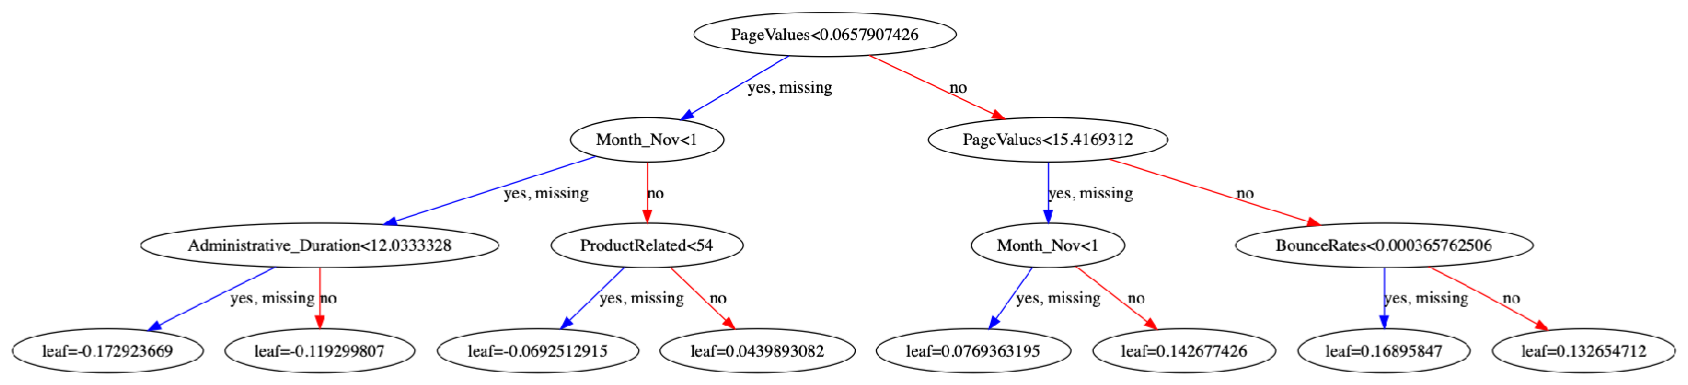

In [16]:
best_model = XGBClassifier(max_depth=3,n_estimators=95,random_state=41, scale_pos_weight=(y_subtrain.values==0).sum()/(y_subtrain.values==1).sum())
best_model_fitted = best_model.fit(X_subtrain, y_subtrain)
plot_tree(best_model_fitted, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(30,30)
fig.show()
y_predict = best_model.predict(X_valid)
print(roc_auc_score(y_valid, y_predict))

# Plot the ROC Curve AUC for the BEST MODEL

[0.00443664 0.287475   0.2604199  ... 0.00340336 0.11137167 0.43761206]
ROC AUC score =  0.8569024077745008


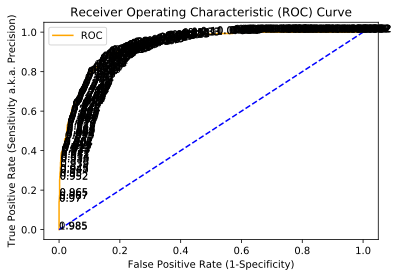

ROC AUC =  0.9327376347725186


In [17]:
from ipywidgets import interactive, FloatSlider
from bokeh.plotting import output_file, figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.layouts import row

# get values for roc curve
probs = best_model_fitted.predict_proba(X_valid)
probs = probs[:,1]
print(probs)
fpr, tpr, thresholds = roc_curve(y_valid, probs, pos_label=1) 


# get area under the curve (AUC)
roc_auc = auc(fpr, tpr)

        
def plot_roc_curve(fpr, tpr):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    for i, txt in enumerate(thresholds):
        ax.annotate(txt.round(decimals=3), (fpr[i], tpr[i]))
    
    
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity a.k.a. Precision)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    print("ROC AUC score = ", roc_auc_score(y_valid,best_model_fitted.predict(X_valid)))
    #
    plt.legend()
    plt.show()
    print("ROC AUC = ",roc_auc)
    
plot_roc_curve(fpr,tpr)     

In [18]:
def make_confusion_matrix(model, threshold):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_valid)[:, 1] >= threshold)
    print(y_predict)
    confusion = confusion_matrix(y_valid, y_predict)
    
    plt.figure(dpi=80)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No Purchase', 'Purchase'],
           yticklabels=['No Purchase', 'Purchase']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

#make_confusion_matrix(best_model_fitted, with a widget to see the changes at each threshold)
interactive(lambda threshold: make_confusion_matrix(best_model_fitted, threshold), threshold=thresholds)


interactive(children=(Dropdown(description='threshold', options=(1.985174, 0.9851739, 0.96954435, 0.9695346, 0…

Plot a clean ROC curve

ROC AUC score 0.86


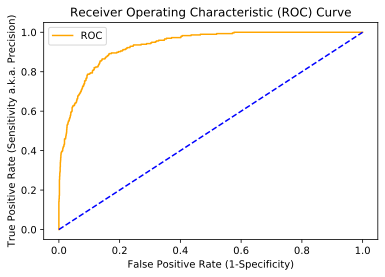

ROC AUC =  0.9327376347725186


In [19]:
def plot_roc_curve(fpr, tpr):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(fpr, tpr, color='orange', label='ROC')
 
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity a.k.a. Precision)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    print("ROC AUC score", round(roc_auc_score(y_valid,best_model_fitted.predict(X_valid)),2))
    plt.legend()
    plt.show()
    print("ROC AUC = ",roc_auc)
    
plot_roc_curve(fpr,tpr)

ROC AUC score 0.86


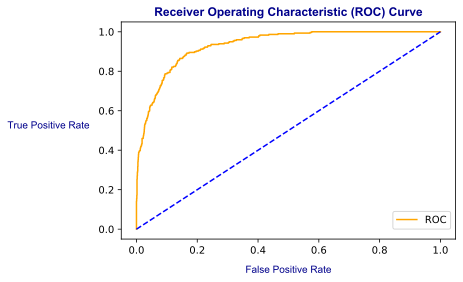

In [77]:
customfont = {'fontname':'Arial'}

def plot_roc_curve(fpr, tpr):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(fpr, tpr, color='orange', label='ROC')
 
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate',**customfont, color='darkblue', labelpad=10)
    plt.ylabel('True Positive Rate',rotation=0, **customfont, color='darkblue', labelpad=50)
    plt.title('Receiver Operating Characteristic (ROC) Curve',fontweight='heavy', **customfont, color='darkblue')
    print("ROC AUC score", round(roc_auc_score(y_valid,best_model_fitted.predict(X_valid)),2))
    plt.legend(bbox_to_anchor=(1, 0.15))
    plt.show()
    
plot_roc_curve(fpr,tpr)


In [78]:
#AFTER PICK BEST MODEL, then look for best decision threshold for ROC for that 1 model (ex. optimizing F1, applying business/domain knowledge for preferring high TPR or FPR) 

fpr, tpr, thresholds = roc_curve(y_valid, probs, pos_label=1) 

df_thresholds = pd.DataFrame(thresholds, columns=['thresholds'])

f1_list = [] 
ROC_AUC_list = []
# FN_list = []
# FP_list = []
# TN_list = []
# TP_list = []
TPR_list = []
FPR_list = []

for decision_threshold in thresholds:
    y_predict = (best_model.predict_proba(X_valid)[:, 1] >= decision_threshold)

    ROC_AUC_list.append(roc_auc_score(y_valid, y_predict))    
    
    f1_list.append(f1_score(y_valid, y_predict))
      
#     tn, fp, fn, tp = confusion_matrix(y_valid,y_predict)
#     FN_list.append(fn)
#     FP_list.append(fp)
#     TN_list.append(tn)
#     TP_list.append(tp)

    fpr, tpr, thresholds = roc_curve(y_valid, y_predict)
    TPR_list.append(tpr)
    FPR_list.append(fpr)
    

df_thresholds['ROC_AUC'] = ROC_AUC_list
df_thresholds['F1'] = f1_list
# df_thresholds['FN'] = FN_list
# df_thresholds['FP'] = FP_list
# df_thresholds['TN'] = TN_list
# df_thresholds['TP'] = TP_list
df_thresholds['TPR (Sensitivity)'] = TPR_list
df_thresholds['FPR (1-Specificity)']= FPR_list

df_thresholds.sort_values('F1',ascending=False)

/Users/kristentokunaga/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,thresholds,ROC_AUC,F1,TPR (Sensitivity),FPR (1-Specificity)
164,0.656602,0.846473,0.678311,"[0.0, 0.7871621621621622, 1.0]","[0.0, 0.09421586165772212, 1.0]"
160,0.661437,0.843989,0.677419,"[0.0, 0.7804054054054054, 1.0]","[0.0, 0.09242695289206918, 1.0]"
162,0.658943,0.845082,0.677372,"[0.0, 0.7837837837837838, 1.0]","[0.0, 0.0936195587358378, 1.0]"
163,0.658192,0.844784,0.676385,"[0.0, 0.7837837837837838, 1.0]","[0.0, 0.09421586165772212, 1.0]"
161,0.659319,0.843393,0.675439,"[0.0, 0.7804054054054054, 1.0]","[0.0, 0.0936195587358378, 1.0]"
...,...,...,...,...,...
467,0.001603,0.500000,0.260908,"[0.0, 1.0]","[0.0, 1.0]"
2,0.969544,0.570946,0.248521,"[0.0, 0.14189189189189189, 1.0]","[0.0, 0.0, 1.0]"
3,0.969535,0.570648,0.247788,"[0.0, 0.14189189189189189, 1.0]","[0.0, 0.0005963029218843172, 1.0]"
1,0.985174,0.501689,0.006734,"[0.0, 0.0033783783783783786, 1.0]","[0.0, 0.0, 1.0]"


In [79]:
interactive(lambda threshold: make_confusion_matrix(best_model_fitted, threshold), threshold=0.656602)
#At this optimized threshold (maximized F1 score), here is my confusion matrix. 

interactive(children=(FloatSlider(value=0.656602, description='threshold', max=1.9698060000000002, min=-0.6566…

# Ready to Re-fit Model to train+CV, predict on test! 

Now with my best model and threshold, we're ready for the big reveal (test data)!

In [80]:
X_test = pd.read_pickle('X_test')
y_test = pd.read_pickle('y_test')

In [81]:
best_model_final_fit = best_model.fit(X_train,y_train)
y_predict_final = (best_model_final_fit.predict_proba(X_test)[:, 1] >= 0.656602)
ROC_AUC_final = roc_auc_score(y_test, y_predict_final)
ROC_AUC_final

0.8198271127782152

Not bad... let's compare to train to see if it overfit

In [82]:
y_predict_final_train = (best_model_final_fit.predict_proba(X_train)[:, 1] >= 0.656602)
ROC_AUC_final_train = roc_auc_score(y_train, y_predict_final_train)
ROC_AUC_final_train

0.8603198699426474

We're within 5%, so the model is not too bad! 

ROC AUC score 0.85


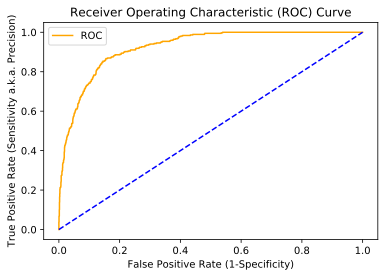

ROC AUC =  0.9235056938284909


In [100]:
probs = best_model_final_fit.predict_proba(X_test)
probs = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=1) 
roc_auc = auc(fpr,tpr)

def plot_roc_curve(fpr, tpr):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(fpr, tpr, color='orange', label='ROC')
 
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity a.k.a. Precision)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    print("ROC AUC score", round(roc_auc_score(y_test, best_model_final_fit.predict(X_test)),2))
    plt.legend()
    plt.show()
    print("ROC AUC = ",roc_auc) 
    fig.savefig('roc.svg',pad_inches=3)
plot_roc_curve(fpr,tpr)


# Feature Importance

Some of the interpretations of the categorical (dummy) variables will be harder to decipher from feature importances, since they are all split across different "features")

However, it's still good to look at how all of these features are impacting my model. Some of the more important features I've identified below have more or less obvious actionable 

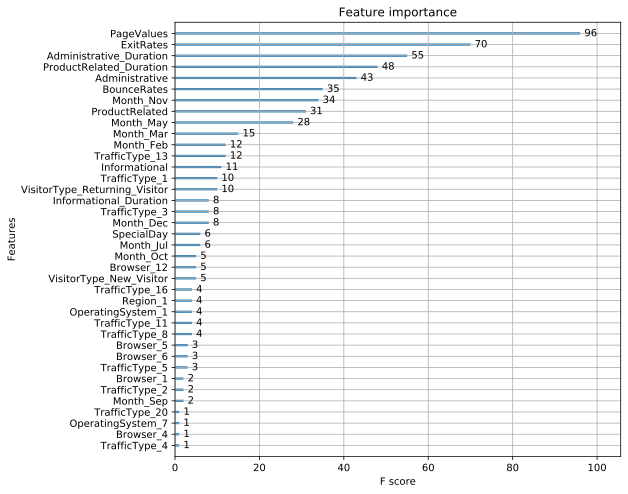

In [97]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_importance(best_model_final_fit, ax, importance_type='weight')
plt.show()
fig.savefig('FeatureImportance_weight.png', bbox_inches='tight')

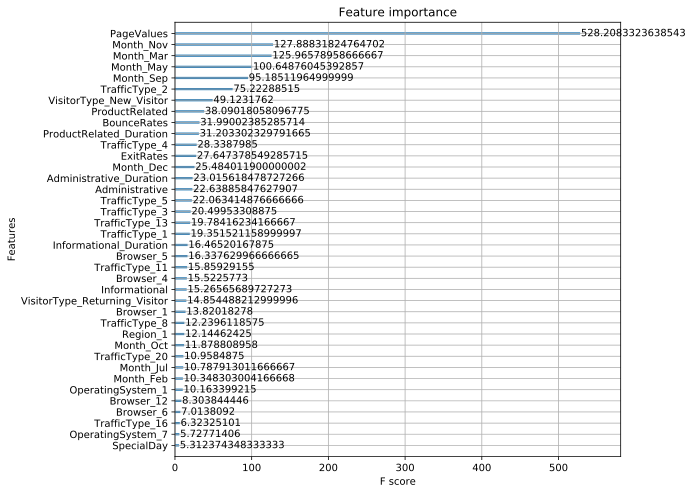

In [98]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_importance(best_model_final_fit, ax, importance_type='gain')
plt.show()
fig.savefig('FeatureImportance_gain.png', bbox_inches='tight')

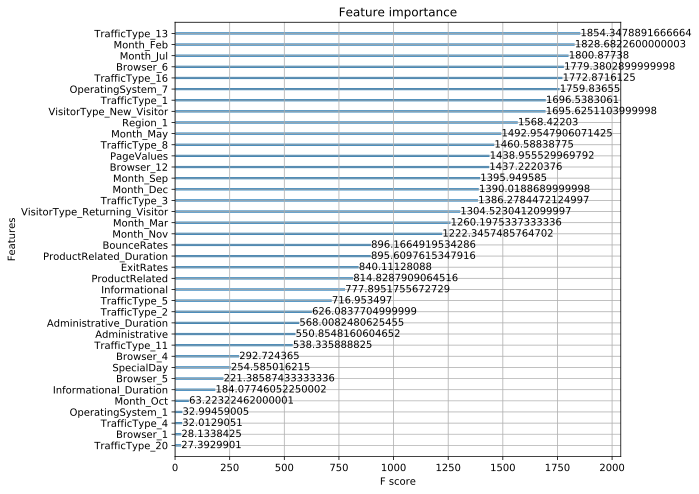

In [99]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_importance(best_model_final_fit, ax, importance_type='cover')
plt.show()
fig.savefig('FeatureImportance_cover.png', bbox_inches='tight')

In [93]:
perm = PermutationImportance(best_model_final_fit).fit(X_test,y_test)
eli5.show_weights(perm)


Weight,Feature
0.1503 ± 0.0061,x8
0.0033 ± 0.0032,x6
0.0022 ± 0.0012,x1
0.0018 ± 0.0006,x21
0.0017 ± 0.0012,x20
0.0015 ± 0.0010,x56
0.0010 ± 0.0008,x3
0.0009 ± 0.0024,x0
0.0003 ± 0.0003,x22
0.0003 ± 0.0008,x9


(0, 68)

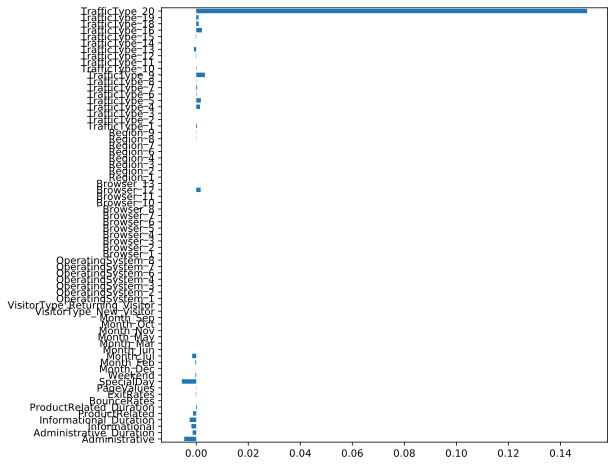

In [98]:
tree_importance_sorted_idx = np.argsort(permuted_feat_importances)

tree_indices = np.arange(0, len(perm.feature_importances_)) + 0.5

fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(tree_indices,
          perm.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax.set_yticklabels(pd.DataFrame(X_train, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20']))
ax.set_yticks(tree_indices)
ax.set_ylim((0, len(perm.feature_importances_)))

AttributeError: 'PermutationImportance' object has no attribute 'T'

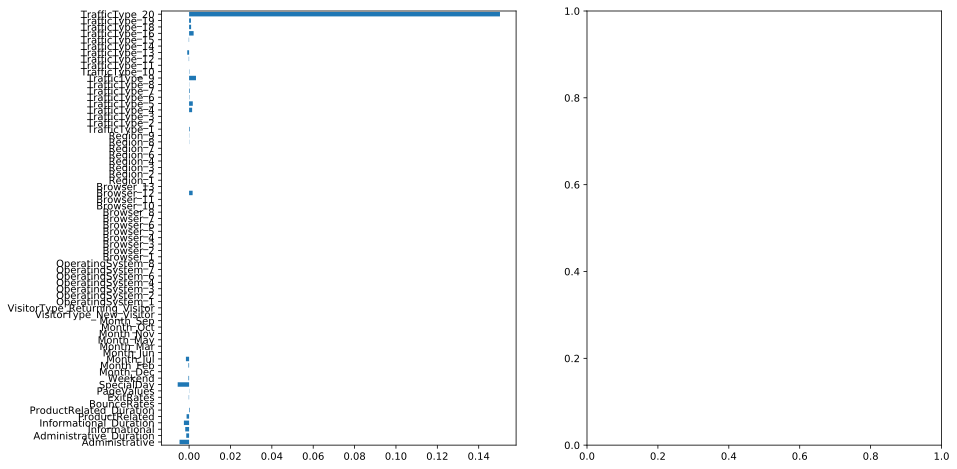

In [95]:
# permuted_feat_importances = perm.feature_importances_

tree_importance_sorted_idx = np.argsort(permuted_feat_importances)

tree_indices = np.arange(0, len(perm.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
ax1.barh(tree_indices,
          perm.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(pd.DataFrame(X_train, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20']))
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(perm.feature_importances_)))
ax2.boxplot(perm.T, vert=False,
            labels=pd.DataFrame(Xtrain, columns = ['Administrative',  'Administrative_Duration',
 'Informational',  'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',  
 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
 'VisitorType_New_Visitor',  'VisitorType_Returning_Visitor', 'OperatingSystem_1', 'OperatingSystem_2',
 'OperatingSystem_3', 'OperatingSystem_4', 'OperatingSystem_6', 'OperatingSystem_7', 'OperatingSystem_8',
 'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5', 'Browser_6', 'Browser_7', 'Browser_8', 'Browser_10',
 'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_6', 'Region_7', 'Region_8', 'Region_9', 
 'TrafficType_1', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
 'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11', 'TrafficType_12', 'TrafficType_13', 'TrafficType_14',
 'TrafficType_15', 'TrafficType_16', 'TrafficType_18', 'TrafficType_19', 'TrafficType_20']))
fig.tight_layout()
plt.show()

In [ ]:
# result = inspection.permutation_importance(best_model, X_ros_resampled_subtrain, y_ros_resampled_subtrain.values.ravel(), n_repeats=10,
#                                 random_state=42)
# perm_sorted_idx = result.importances_mean.argsort()

# tree_importance_sorted_idx = np.argsort(best_model.feature_importances_)
# tree_indices = np.arange(0, len(best_model.feature_importances_)) + 0.5

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# ax1.barh(tree_indices,
#          best_model.feature_importances_[tree_importance_sorted_idx], height=0.7)
# ax1.set_yticklabels(data.feature_names)
# ax1.set_yticks(tree_indices)
# ax1.set_ylim((0, len(best_model.feature_importances_)))
# ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
#             labels=data.feature_names)
# fig.tight_layout()
# plt.show()

In [ ]:
from mlxtend.evaluate import feature_importance_permutation

imp_vals, _ = feature_importance_permutation(
    predict_method=best_model_fitted.predict, 
    X=X_valid,
    y=y_valid,
    metric='accuracy',
    num_rounds=1,
    seed=1)

imp_vals